# `deshift`: Distributionally Robust Optimization in PyTorch

In this tutorial, we describe how to use `deshift` to solve distributionally robust optimization problems using the standard PyTorch training loop. Please read the Quickstart guide for a introduction to the package.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from tqdm import tqdm
import matplotlib.pyplot as plt

import sys
sys.path.append("..")
from deshift import make_spectral_risk_measure, make_extremile_spectrum

## Download and View Data

We use the FashionMNIST dataset as an example. Importantly, when constructing dataloaders, we specify the `drop_last=True` argument so that the batches remain the same size. This is because the oracle that compute the weights on each example depends on a fixed sample size.

In [2]:
root = "../data/"

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(0.5, 0.5)])

train_data = FashionMNIST(root, download=True, transform=transform)
test_data = FashionMNIST(root, download=True, train=False, transform=transform)

100%|██████████| 26421880/26421880 [00:04<00:00, 6130085.89it/s]


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 167838.35it/s]


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:06<00:00, 723918.80it/s]


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 9157030.11it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



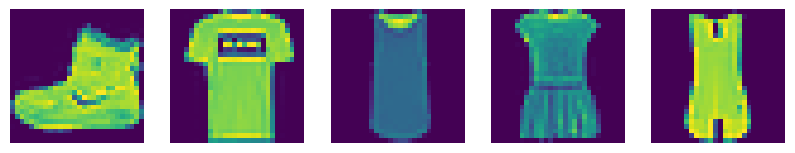

In [3]:
n_plots = 5
fig, axes = plt.subplots(1, n_plots, figsize=(2 * n_plots, 2))
for i, ax in enumerate(axes):
    image = train_data.data[i]
    ax.axis("off")
    ax.imshow(image)
plt.show()

In [4]:
batch_size = 128

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, drop_last=True)

## Define Model

We use a standard convolutional neural network (CNN) architecture for this example.

In [5]:
class ConvNet(nn.Module):
    def __init__(self, hidden_dim=512, n_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(64*3*3, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, n_classes)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)  # conv1
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)  # conv2
        x = F.max_pool2d(F.relu(self.conv3(x)), 2) # conv3 
        x = x.view(x.shape[0], -1) # flatten
        features = self.fc1(x)
        x = F.relu(features)
        return self.fc2(x)

## Construct Distributionally Robust Objective

Here, we construct the function that computes 
$$
l \mapsto \operatorname{argmax}_{q \in \mathcal{Q}} q^\top l - \nu D(q \Vert \mathbf{1}_n/n)
$$
for some vector $l \in \mathbb{R}^n$. We specify the shape of $\mathcal{Q}$ using the `spectrum` argument, $D$ using the `penalty` argument, and $\nu$ using the `shift_cost` argument. The result is a function that maps a vector of length `n` to a set of `n` non-negative weights that sum to one.

In [6]:
shift_cost = 1.0
penalty = "chi2" # options: 'chi2', 'kl'

# define spectrum based on the 2-extremile
spectrum = make_extremile_spectrum(batch_size, 2.0)

# create function which computes weight on each example
compute_sample_weight = make_spectral_risk_measure(spectrum, penalty=penalty, shift_cost=shift_cost)

## Train Model

Next, we train the model using a standard PyTorch training loop. The only addition is that we compute the losses on a per-example basis by specifying `reduction="none"` in the loss function computation. Under the hood, we then move the losses to CPU and convert them to a `numpy` array in order to compute the sample weights. The weights are computed on CPU in order to make use of just-in-time compilation, as algorithms for computing the exact maximum often involve iterative procedures that are not anemanble to parallelizable matrix operations. The losses are then aggregated using these weights, resulting in the final objective from which we backpropagate.

In [7]:
lr = 1e-5
device = "cuda"
n_epochs = 5

model = ConvNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [8]:
@torch.no_grad()
def evaluate(model, loader):
    total_accuracy = 0.0
    for (x, y) in loader:
        x = x.to(device)
        y = y.to(device)
        y_pred = torch.argmax(model(x), dim=1)
        total_accuracy += torch.sum(y == y_pred) / len(x)
    return total_accuracy / len(loader)


for epoch in tqdm(range(n_epochs)):
    for i, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)

        logits = model(x)
        losses = F.cross_entropy(logits, y, reduction="none")

        # one line of code addition!
        weights = compute_sample_weight(losses)

        loss = weights @ losses
        loss.backward()

        optimizer.step()

    print(f"epoch {epoch}:")
    train_acc = evaluate(model, train_loader)
    test_acc = evaluate(model, test_loader)
    print(f"\t train acc: {train_acc}")
    print(f"\t test acc:  {test_acc}")

  0%|          | 0/5 [00:00<?, ?it/s]/home/ronak/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


epoch 0:


 20%|██        | 1/5 [00:19<01:16, 19.18s/it]

	 train acc: 0.5850861668586731
	 test acc:  0.5845352411270142
epoch 1:


 40%|████      | 2/5 [00:35<00:52, 17.62s/it]

	 train acc: 0.7103699445724487
	 test acc:  0.7043269276618958
epoch 2:


 60%|██████    | 3/5 [00:52<00:34, 17.19s/it]

	 train acc: 0.7741052508354187
	 test acc:  0.770432710647583
epoch 3:


 80%|████████  | 4/5 [01:08<00:16, 16.89s/it]

	 train acc: 0.7911491990089417
	 test acc:  0.7861578464508057
epoch 4:


100%|██████████| 5/5 [01:25<00:00, 17.11s/it]

	 train acc: 0.8073250651359558
	 test acc:  0.7990785241127014
